![](https://www.winet.dcc.ufmg.br/wp-content/uploads/2019/09/dcc.gif)

## Universidade Federal de Minas Gerais 
## ICEX - Departamento de Ciência de Computação

### Trabalho de Aprendizado de Máquina 2
 
##### Professor Dr. Adriano Veloso 
###### Aluno: Jesimon Barreto Santos - 2016070093

### Importações

In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from copy import copy
import statistics as sts
import scipy.stats as st
from math import *

#!pip install pandas
import pandas as pd

from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.manifold import TSNE

### Carregar e Preprocessar dataset

Carrega os dados e os colocam no formato de amostras(X) e anorações(y). Além de dividir em folds.

In [2]:
#Carrega os dados
data = pd.read_csv('tic-tac-toe.data', names=['1', '2', '3','4','5', '6', '7','8', '9', 'y'])
#Separando a anotação
y = data.pop('y').values
#Codificando a anotação para numérico
labelencoder = LabelEncoder()
y = labelencoder.fit_transform(y)
print('Tamanho do vetor y: {}'.format(len(y)))
#Pegando apenas as features de cada amostra para treinar
X = data.values
print('Tamanho do vetor X: {}'.format(X.shape))#Dividindo em 5 partes de treino e teste, ou seja, 5 folds
kf = KFold(n_splits=5, shuffle=True, random_state=123)
print('Tamanho do vetor das folds:')
for train, test in kf.split(X):
    print("  TRAIN:", train.shape, "TEST:", test.shape)

Tamanho do vetor y: 958
Tamanho do vetor X: (958, 9)
Tamanho do vetor das folds:
  TRAIN: (766,) TEST: (192,)
  TRAIN: (766,) TEST: (192,)
  TRAIN: (766,) TEST: (192,)
  TRAIN: (767,) TEST: (191,)
  TRAIN: (767,) TEST: (191,)


### Classe Stump
Essa é a classe que representa o classificador fraco. Árvore de decisão de profundidade 1. Além de considerar os pesos.
- As princiais funções são fit_stump e predict_stump.

In [55]:
class Stump:
    def __init__(self):
        self.gains = []
        self.col = -1
        self.max_gain = -1
        self.values = []
        self.answer = {}
    
    def decision_accuracy(self, y_):
        if np.sum(y_) <= y_.shape[0]/2:
            return -1
        return 1
        
    def gain(self, col, w, y_, sbl):
        #sbl = [x,o,b] # x,b,o
        EH = 0
        for i in sbl:
            pst= np.where(col==i)[0]
            y_slt = y_[pst] 
            posit = np.where(y_slt == 1)[0]
            negat = np.where(y_slt == 0)[0]
            pos = np.sum(w[posit])
            neg = np.sum(w[negat])
            EH += ((len(y_slt)/len(y_)) * self.entropia(pos,neg))
        
        posit = np.where(y_ == 1)[0]
        negat = np.where(y_ == 0)[0]
        pos = np.sum(w[posit])
        neg = np.sum(w[negat])
        I = self.entropia(pos,neg) - EH
        return I
        
    def entropia(self, P, N):
        if (P == 0) or (N == 0):
            H = 0
        else:
            H = -(P/(P+N))*log2(P/(P+N)) - (N/(P+N))*log2(N/(P+N))
        return H

    def fit_stump(self, X_train, y_train, w=[]):
        #calcula ganho para cada atributo
        X_train = np.asarray(X_train)
        y_train = np.asarray(y_train)
        w = np.asarray(w)
        if w.size == 0:
            n = y_train.shape[0]
            w = np.array(n*[1/n])
        
        len_cols = X_train.shape[-1]
        self.gains = []
        for col in range(len_cols):
            att = X_train[:,col]
            sbl = np.unique(X_train[:,col])
            self.gains.append(self.gain(att, w, y_train, sbl))
        self.gains = np.array(self.gains)
        mx_gain = np.amax(self.gains)
        print(self.gains)
        idx_max = np.where(self.gains == np.amax(mx_gain))[0][0]
        self.col = idx_max
        self.max_gain = mx_gain
        
        #calcular values
        self.values = np.unique(X_train[:,idx_max])
        #saber qual classe vai ser dada a cada um dos valores possiveis da class
        self.answer = {} 
        for v in self.values:
            posi = np.where(X_train[:,idx_max] == v)[0]
            y_value = y_train[posi]
            ans = self.decision_accuracy(y_value)
            self.answer[v] = ans
            
    def predict_stump(self, X_test):
        #ct pode ser igual a x,o,b
        samples = np.asarray(X_test)
        result = []
        for smp in samples:
            ct = smp[self.col]
            if ct in self.answer:
                result.append(self.answer[ct])
            else:
                result.append(-1)
        
        return np.array(result)


### Classe Adabosting
Essa é a classe que representa o boosting. Que contem a lógica geral do classificador.
- As princiais funções são fit e predict.

In [68]:
class AdaBosting:
    def __init__(self):
        self.models = []
        self.alphas = []
        self.err = []
        self.D_ = []
    
    def fit(self, X_train, y_train, K = 1):
        N = len(X_train)
        H = []
        D= []
        alpha = []
        D.append(N*[1/N])

        for k in range(1,K+1):
            w = D[k-1]
            #arvore 1 altura e peso de amostra w = Di
            h = Stump()
            h.fit_stump(X_train, y_train, w)
            self.models.append(h)
            y_pred = h.predict_stump(X_train)
            pred_cor = np.where(y_pred == y_train,1,0)
            pred_incor = np.where(y_pred != y_train,1,0)
            accuracy = sum(pred_cor)/len(pred_cor)
            misclas = sum(pred_incor)/len(pred_incor)
            err_l = np.sum(w*pred_incor)#/np.sum(w)
            self.err.append(err_l)
            a = log2((1-err_l)/err_l)/2
            alpha.append(a)
            D_new = w*np.exp(a*pred_incor)
            D_new = D_new/np.sum(D_new)
            D.append(D_new)
        
        self.alphas = alpha
        self.D_ = D

    def predict(self, X_test):
        predic = []
        X_test = np.asarray(X_test)

        for sample in X_test:
            pred = []
            for alpha,model in zip(self.alphas,self.models):
                sample = sample.reshape(1,-1)
                pred_f = alpha*model.predict_stump(sample) 
                pred.append(pred_f)
            cls = np.sign(np.sum(np.array(pred),axis=0))
            
            if cls[0] < 0:
                predic.append(0)
            else:
                predic.append(1)

                    
        return np.array(predic)


### Execução do Algoritmo
- Executando o algoritmo implementado e variando os hiperparâmetros 
- Apresenta o resultado da acurácia, revocação e precisão com seus respectivos intervalos de confiança

In [69]:
'''stp = Stump()
stp.fit_stump(X_train, y_train)
s =stp.predict_stump(X_train)
print(s)'''

for train, test in kf.split(X):
        print("  TRAIN:", train.shape, "TEST:", test.shape)
        X_train, X_test = X[train], X[test]
        y_train, y_true = y[train], y[test] 
        #criando classificador
        ada = AdaBosting()
        ada.fit(X_train, y_train, K = 100)
        #predição nos dados de teste
        y_pred = ada.predict(X_test)
        print(y_pred)
        print(y_true)
        print(ada.alphas)
        #metricas
        acc = accuracy_score(y_true, y_pred)
        print(acc)
        break

  TRAIN: (766,) TEST: (192,)
[0.01807915 0.00724769 0.02272359 0.01066672 0.08648467 0.00914464
 0.01711181 0.00853583 0.01087645]
[0.01951171 0.00857433 0.02415048 0.01201795 0.0878142  0.01050846
 0.01854117 0.00983404 0.01229184]
[0.01990917 0.00894216 0.02454635 0.01239265 0.08818287 0.0108867
 0.01893773 0.01019393 0.0126845 ]
[0.02001979 0.00904452 0.02465653 0.01249692 0.08828546 0.01099195
 0.01904809 0.01029407 0.01279377]
[0.02005061 0.00907303 0.02468722 0.01252596 0.08831404 0.01102127
 0.01907884 0.01032196 0.01282421]
[0.02005919 0.00908097 0.02469577 0.01253406 0.088322   0.01102944
 0.0190874  0.01032973 0.0128327 ]
[0 0 0 0 0 1 1 1 1 1 1 0 0 0 1 1 0 1 1 1 1 0 1 0 1 1 1 1 1 0 0 1 1 1 1 1 1
 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 0 0 1 1 1 0 1 1 0 1 1 0 1
 1 0 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 1 1 1 1 1 0 0 1 1 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 1 1 1 1 0 0 1 1 1 1 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 1 0
 1 1 0 0 0 0 1 0 0 0 0 0 1 1 1 1 1 1 0 0 1 0 1 1 0 1 0 0 0 0

In [58]:


K =list(range(1,10))

acc_plot, rec_plot, prec_plot = [],[],[]
acc_err_plot, rec_err_plot, prec_err_plot = [], [], []

for k in K:
    acc_final, recall_final, precision_final = [], [], []
    y_true_f, y_pred_f = [],[]
    for train, test in kf.split(X):
        print("  TRAIN:", train.shape, "TEST:", test.shape)
        X_train, X_test = X[train], X[test]
        y_train, y_true = y[train], y[test] 
        #criando classificador
        ada = AdaBosting()
        ada.fit(X_train, y_train, K = k)
        #predição nos dados de teste
        y_pred = ada.predict(X_test)
        #metricas
        acc = accuracy_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred, average='macro')
        precision = precision_score(y_true, y_pred, average='macro')
        
        y_true_f.append(y_true)
        y_pred_f.append(y_pred)

        acc_final.append(acc)
        recall_final.append(recall)
        precision_final.append(precision)

    #calculando intervalo de confiança
    ic_acc = st.t.interval(0.9, len(acc_final) - 1, loc=np.mean(acc_final), scale=st.sem(acc_final))
    ic_recall = st.t.interval(0.9, len(recall_final) - 1, loc=np.mean(recall_final), scale=st.sem(recall_final))
    ic_pre = st.t.interval(0.9, len(precision_final) - 1, loc=np.mean(precision_final), scale=st.sem(precision_final))
    print('Mean Accuracy[{:.4f}] IC [{:.4f}, {:.4f}]'.format(np.mean(acc_final), ic_acc[0], ic_acc[1]))
    print('Mean Recall[{:.4f}] IC [{:.4f}, {:.4f}]'.format(np.mean(recall_final), ic_recall[0], ic_recall[1]))
    print('Mean Precision[{:.4f}] IC [{:.4f}, {:.4f}]'.format(np.mean(precision_final), ic_pre[0], ic_pre[1]))
    acc_plot.append(np.mean(acc_final))
    acc_err_plot.append(ic_acc)
    rec_plot.append(np.mean(recall_final))
    rec_err_plot.append(ic_recall)
    prec_plot.append(np.mean(precision_final))
    prec_err_plot.append(ic_pre)



  TRAIN: (766,) TEST: (192,)
[0.01807915 0.00724769 0.02272359 0.01066672 0.08648467 0.00914464
 0.01711181 0.00853583 0.01087645]
  TRAIN: (766,) TEST: (192,)
[0.01299321 0.007208   0.01455912 0.00706456 0.08234981 0.00417395
 0.01334048 0.00316629 0.01042472]
  TRAIN: (766,) TEST: (192,)
[0.01187708 0.00549688 0.009134   0.01078458 0.09507582 0.00480059
 0.00914214 0.00539241 0.01270105]
  TRAIN: (767,) TEST: (191,)
[0.01599378 0.00756711 0.01113637 0.00451124 0.08341332 0.01378884
 0.01679168 0.01070529 0.01600382]
  TRAIN: (767,) TEST: (191,)
[0.01246651 0.00823466 0.01258066 0.0045389  0.0905969  0.0064202
 0.01314789 0.01020282 0.01936454]
Mean Accuracy[0.4017] IC [0.2665, 0.5370]
Mean Recall[0.2660] IC [0.1221, 0.4099]
Mean Precision[0.2264] IC [0.1850, 0.2677]
  TRAIN: (766,) TEST: (192,)
[0.01807915 0.00724769 0.02272359 0.01066672 0.08648467 0.00914464
 0.01711181 0.00853583 0.01087645]
[0.01951171 0.00857433 0.02415048 0.01201795 0.0878142  0.01050846
 0.01854117 0.00983404 

/home/jesimon/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/jesimon/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[0.01187708 0.00549688 0.009134   0.01078458 0.09507582 0.00480059
 0.00914214 0.00539241 0.01270105]
[0.01256432 0.0061594  0.00983128 0.01141765 0.09570797 0.00544803
 0.00982361 0.00603683 0.01339671]
[0.01275537 0.00634355 0.01002514 0.01159358 0.09588366 0.00562797
 0.01001306 0.00621593 0.01359011]
  TRAIN: (767,) TEST: (191,)
[0.01599378 0.00756711 0.01113637 0.00451124 0.08341332 0.01378884
 0.01679168 0.01070529 0.01600382]
[0.01635633 0.00791391 0.01149507 0.004859   0.08375684 0.01413103
 0.01715275 0.0110522  0.01636543]
[0.01645725 0.00801044 0.01159491 0.0049558  0.08385246 0.01422627
 0.01725325 0.01114876 0.01646609]
  TRAIN: (767,) TEST: (191,)
[0.01246651 0.00823466 0.01258066 0.0045389  0.0905969  0.0064202
 0.01314789 0.01020282 0.01936454]
[ 0.00737537  0.00362246  0.00742868 -0.00020615  0.08581794  0.00161505
  0.00800408  0.00547671  0.01425052]
[ 0.00593188  0.0023106   0.00596852 -0.0015544   0.08446049  0.00025012
  0.00654614  0.00413352  0.01280069]
Mean Ac

[ 0.00552772  0.00194299  0.00555974 -0.00193211  0.08408023 -0.00013224
  0.00613797  0.00375721  0.01239477]
[ 0.00541495  0.00184039  0.00544568 -0.00203752  0.08397411 -0.00023894
  0.00602408  0.00365219  0.01228151]
[ 0.00538352  0.00181179  0.00541389 -0.0020669   0.08394453 -0.00026868
  0.00599234  0.00362291  0.01224994]
Mean Accuracy[0.4017] IC [0.2665, 0.5370]
Mean Recall[0.2660] IC [0.1221, 0.4099]
Mean Precision[0.2264] IC [0.1850, 0.2677]
  TRAIN: (766,) TEST: (192,)
[0.01807915 0.00724769 0.02272359 0.01066672 0.08648467 0.00914464
 0.01711181 0.00853583 0.01087645]
[0.01951171 0.00857433 0.02415048 0.01201795 0.0878142  0.01050846
 0.01854117 0.00983404 0.01229184]
[0.01990917 0.00894216 0.02454635 0.01239265 0.08818287 0.0108867
 0.01893773 0.01019393 0.0126845 ]
[0.02001979 0.00904452 0.02465653 0.01249692 0.08828546 0.01099195
 0.01904809 0.01029407 0.01279377]
[0.02005061 0.00907303 0.02468722 0.01252596 0.08831404 0.01102127
 0.01907884 0.01032196 0.01282421]
[0.0

  TRAIN: (766,) TEST: (192,)
[0.01299321 0.007208   0.01455912 0.00706456 0.08234981 0.00417395
 0.01334048 0.00316629 0.01042472]
[0.01299321 0.007208   0.01455912 0.00706456 0.08234981 0.00417395
 0.01334048 0.00316629 0.01042472]
[0.01299321 0.007208   0.01455912 0.00706456 0.08234981 0.00417395
 0.01334048 0.00316629 0.01042472]
[0.01299321 0.007208   0.01455912 0.00706456 0.08234981 0.00417395
 0.01334048 0.00316629 0.01042472]
[0.01299321 0.007208   0.01455912 0.00706456 0.08234981 0.00417395
 0.01334048 0.00316629 0.01042472]
[0.01299321 0.007208   0.01455912 0.00706456 0.08234981 0.00417395
 0.01334048 0.00316629 0.01042472]
[0.01299321 0.007208   0.01455912 0.00706456 0.08234981 0.00417395
 0.01334048 0.00316629 0.01042472]
[0.01299321 0.007208   0.01455912 0.00706456 0.08234981 0.00417395
 0.01334048 0.00316629 0.01042472]
[0.01299321 0.007208   0.01455912 0.00706456 0.08234981 0.00417395
 0.01334048 0.00316629 0.01042472]
  TRAIN: (766,) TEST: (192,)
[0.01187708 0.00549688 0

### Gráficos e Análises
- Geração de gráficos para análise do algoritmo implementado.

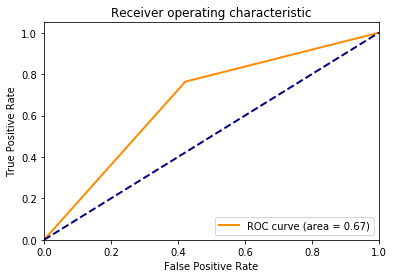

(9, 2)


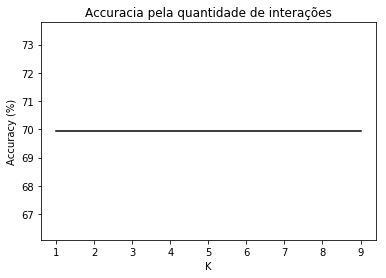

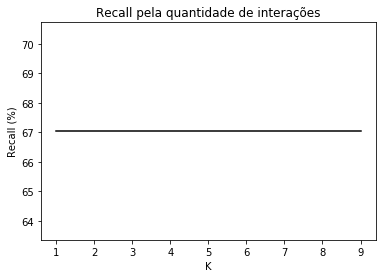

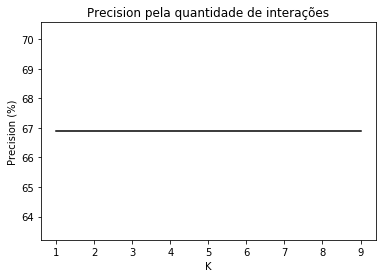

In [12]:
#plot curva ROC do ultimo valor de k
y_pred = np.concatenate(y_pred_f, axis=0)
y_true = np.concatenate(y_true_f, axis=0)
fpr, tpr, _ = roc_curve(y_true, y_pred)
auc_ = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc_)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

##plot com erro
acc_plot = np.array(acc_plot)*100
erro = np.array(acc_err_plot)
print(erro.shape)
fig, ax = plt.subplots()
ax.plot(K, acc_plot, 'k-')
#plt.xlim([min(depths), max(depths)])
#plt.ylim([0, 100])
ax.set(xlabel='K', ylabel='Accuracy (%)',
       title='Accuracia pela quantidade de interações')
#plt.legend(loc="lower right")
plt.show()

##plot com erro
rec_plot = np.array(rec_plot)*100
erro = np.array(rec_err_plot)
fig, ax = plt.subplots()
ax.plot(K, rec_plot, 'k-')
#plt.xlim([min(depths), max(depths)])
#plt.ylim([0, 100])
ax.set(xlabel='K', ylabel='Recall (%)',
       title='Recall pela quantidade de interações')
#plt.legend(loc="lower right")
plt.show()

##plot com erro
prec_plot = np.array(prec_plot)*100
erro = np.array(prec_err_plot)
fig, ax = plt.subplots()
ax.plot(K, prec_plot, 'k-')
ax.set(xlabel='K', ylabel='Precision (%)',
       title='Precision pela quantidade de interações')
#plt.legend(loc="lower right")

plt.show()    
